In [27]:

!pip install seaborn

import html
import numpy as np
import re
from convokit import Corpus, download
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import json
import spacy
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


nlp = spacy.load("en_core_web_sm")


       
from sklearn.metrics import cohen_kappa_score
import krippendorff

def get_cohens_kappa(json_data, df):
    y_true, y_pred = [], []

    for key, entry in json_data["data"].items():
        idx = int(key) - 1
        gold = str(df.loc[idx, "isOthering"]).strip().lower()
        pred = str(entry["annotation"]["label"]).strip().lower()
        y_true.append(gold)
        y_pred.append(pred)

    return cohen_kappa_score(y_true, y_pred)



def krippendorff_alpha(json_data, df):
    y_true, y_pred = [], []

    for key, entry in json_data["data"].items():
        idx = int(key) - 1
        gold = str(df.loc[idx, "isOthering"]).strip().lower()
        pred = str(entry["annotation"]["label"]).strip().lower()
        y_true.append(gold)
        y_pred.append(pred)

    data = [y_true, y_pred]  # rows = annotators, cols = items
    return krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')

# Method definitions
def load_dataset_dynamic(corpus, start_index, end_index):
    return Corpus(
        filename=download(corpus),
        backend="mem",
        utterance_start_index=start_index,
        utterance_end_index=end_index,
    )


def load_dataset_to_memory(corpus_path):
    return Corpus(filename=corpus_path, backend="mem")


def get_target_ids(corpus):
    target_ids = []

    othering_terms = [
        # Dehumanizing terms (animals, pests, disease metaphors)
        "animal",
        "beast",
        "savage",
        "barbaric",
        "subhuman",
        "primitive",
        "parasite",
        "vermin",
        "rat",
        "cockroach",
        "monster",
        "brute",
        "ape",
        "gorilla",
        "monkey",
        "dog",
        "pig",
        "swine",
        "goat",
        "bug",
        "leech",
        "tick",
        "lice",
        "maggot",
        "worm",
        "cancer",
        "tumor",
        "virus",
        "plague",
        "infection",
        "disease",
        # Moral judgment / worthlessness
        "scum",
        "trash",
        "filth",
        "worthless",
        "inferior",
        "degenerate",
        "lowlife",
        "unworthy",
        "unclean",
        "impure",
        "corrupt",
        "dirty",
        "disgusting",
        "vile",
        "evil",
        "wicked",
        "sinful",
        "cursed",
        "burden",
        "freeloader",
        "sponger",
        # Threatening / dangerous
        "dangerous",
        "violent",
        "aggressive",
        "hostile",
        "criminal",
        "thug",
        "deviant",
        "radical",
        "extremist",
        "fundamentalist",
        "terrorist",
        "predator",
        "rapist",
        "gangster",
        "invader",
        "occupier",
        "conqueror",
        "infiltrator",
        "threat",
        # Exclusion / separation
        "outsider",
        "intruder",
        "alien",
        "stranger",
        "foreigner",
        "enemy",
        "unwelcome",
        "illegal",
        "unwanted",
        "expat",
        "outcast",
        "undesirable",
        "colonizer",
        "settler",
        # Diminishing / infantilizing
        "ignorant",
        "backward",
        "naive",
        "uncivilized",
        "helpless",
        "weak",
        "stupid",
        "lazy",
        "immature",
        "childlike",
        "silly",
        "emotional",
        "hysterical",
        "irrational",
        "clueless",
        "brainwashed",
        "sheep",
        "puppet",
        "follower",
        # Religion & secular identities
        "atheists",
        "non-believers",
        "secular people",
        "buddhists",
        "buddhist people",
        "hindus",
        "hindu people",
        "christians",
        "christian people",
        "catholics",
        "protestants",
        "mormons",
        "evangelicals",
        "pagans",
        "satanists",
        "muslims",
        "islamic people",
        "islamists",
        "muzzies",
        "ragheads",
        "jews",
        "jewish people",
        "zionists",
        "orthodox jews",
        # Migration / nationality
        "immigrants",
        "migrants",
        "foreigners",
        "outsiders",
        "refugees",
        "asylum seekers",
        "expats",
        "nationals",
        "illegal aliens",
        "illegals",
        "invaders",
        "colonizers",
        "settlers",
        # Gender & women
        "women",
        "woman",
        "girl",
        "girls",
        "females",
        "ladies",
        "wives",
        "mothers",
        "bitches",
        "sluts",
        "whores",
        "feminists",
        "feminazis",
        # LGBTQ+
        "lgbtq",
        "gay",
        "gays",
        "lesbian",
        "lesbians",
        "bisexual",
        "transgender",
        "trans",
        "tranny",
        "trannies",
        "queer",
        "queers",
        "dyke",
        "dykes",
        "faggot",
        "faggots",
        "non-binary",
        "drag queens",
        "drag kings",
    ]

    # Pre-compile regex patterns
    patterns = [
        re.compile(r"(?i)(?<!\w)" + re.escape(term) + r"(?!\w)")
        for term in othering_terms
    ]

    for utt in corpus.iter_utterances():
        if not utt.text:  # skip empty text
            continue

        # Count words
        word_count = len(utt.text.split())

        if word_count < 100 and any(p.search(utt.text) for p in patterns):
            target_ids.append(utt.id)

    return target_ids


def get_id_chain(corpus, target_id):
    chain = []
    utt = corpus.get_utterance(target_id)
    while utt is not None:
        chain.append(utt)
        utt = corpus.get_utterance(utt.reply_to) if utt.reply_to else None

    # reverse so it's from root → target
    chain = chain[::-1]
    return chain


def plot_wordcloud(chain, title):
    all_words = " ".join(u.text for u in chain).lower()
    wordcloud = WordCloud(
        width=800, height=400, background_color="white", stopwords=STOPWORDS
    ).generate(all_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

def export_comments_to_json(corpus, target_ids, filepath):
    """
    Export selected comments into JSON format:
    one big JSON object with numeric keys.
    """
    results = {}

    for idx, target_id in enumerate(target_ids, start=1):
        utt = corpus.get_utterance(target_id)
        if utt is None:
            continue

        # build id chain
        id_chain = []
        for i in get_id_chain(corpus, target_id):
            id_chain.append({"id": i.id})

        # get up to 3 preceding comments
        last_idx = len(id_chain) - 1
        start = max(0, last_idx - 3)
        end = last_idx
        context_ids = id_chain[start:end]

        # collect context text
        context_text = []
        for entry in context_ids:
            ctx_utt = corpus.get_utterance(entry["id"])
            if ctx_utt and ctx_utt.text:
                context_text.append(ctx_utt.text)

        # extract top keywords from context
        context = categorize_chunks(" ".join(context_text), top_n=10)

        # build record
        record = {
            "id": target_id,
            "text": getattr(utt, "text", None),
            "timestamp": getattr(utt, "timestamp", None),
            "conversation_id": getattr(utt, "conversation_id", None),
            "comment_chain": id_chain,
            "context": context,
        }
        results[idx] = record  # numeric keys

    # save to JSON
    with open(filepath, "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2, ensure_ascii=False)

    print(f"✅ Saved {len(results)} comments to {filepath} (JSON format)")



def export_comments_to_jsonl(corpus, target_ids, filepath):
    """
    Export selected comments into JSONL format:
    one JSON object per line.
    """
    count = 0
    with open(filepath, "w", encoding="utf-8") as f:
        for target_id in target_ids:
            utt = corpus.get_utterance(target_id)
            if utt is None:
                continue
            
            id_chain = []
            context = []
    
            for i in get_id_chain(corpus, target_id):
                id_chain.append({"id": i.id})
    
            last_idx = len(id_chain) - 1
            start = max(0, last_idx - 3)  # up to 3 preceding comments
            end = last_idx
            context_ids = id_chain[start:end]

            context_text = []
            for id in context_ids:
                context_text.append(corpus.get_utterance(id["id"]).text)

            context = categorize_chunks(" ".join(context_text), top_n=10)

            record = {
            "id": target_id,
            "text": getattr(utt, "text", None),
            "timestamp": getattr(utt, "timestamp", None),
            "conversation_id": getattr(utt, "conversation_id", None),
            "comment_chain": id_chain,
            "context": context,
            }
            f.write(json.dumps(record, ensure_ascii=False) + "\n")
            count += 1

    print(f"✅ Saved {count} comments to {filepath} (JSONL format)")
    
def categorize_chunks(text, top_n=10):
    doc = nlp(text)

    # collect candidate words/phrases
    candidates = []
    for chunk in doc.noun_chunks:
        phrase = chunk.text.lower().strip()
        if not all(token.is_stop for token in chunk):  # skip only-stopword chunks
            candidates.append(phrase)

    # deduplicate while preserving order
    seen, keywords = set(), []
    for c in candidates:
        if c not in seen:
            seen.add(c)
            keywords.append(c)

    return keywords[:top_n]

def clean_text(text: str) -> str:
    # Collapse multiple newlines into one space
    text = re.sub(r"\s*\n\s*", " ", text)
    # Collapse multiple spaces
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def clean_links(text: str, keep_anchor=True):
    # Remove markdown-style links [text](url)
    if keep_anchor:
        return re.sub(r"\[([^\]]+)\]\([^)]+\)", r"\1", text)
    else:
        return re.sub(r"\[([^\]]+)\]\([^)]+\)", "[URL]", text)
    
def clean_html_tags(text: str) -> str:
   return html.unescape(text)


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [3]:
corpus = load_dataset_dynamic("reddit-corpus-small", 0, 10000)
target_ids = get_target_ids(corpus)

# for target_id in target_ids:
#     chain = get_id_chain(corpus, target_id)
#     for u in chain:
#         print(f"{u.id}")
#     print("-----")

# print(target_ids)

Dataset already exists at C:\Users\hofin\.convokit\saved-corpora\reddit-corpus-small


In [44]:
import os
#target_ids = get_target_ids(corpus)

os.chdir(r"C:\Users\hofin\OneDrive - Fachhochschule St. Pölten\__BachelorThesis\blast_othering")


export_comments_to_json(corpus, target_ids, "data_collection/reddit-corpus-small.json")

✅ Saved 17532 comments to data_collection/reddit-corpus-small.json (JSON format)


In [7]:
os.chdir(r"C:\Users\hofin\OneDrive - Fachhochschule St. Pölten\__BachelorThesis\blast_othering")

with open("data_collection/reddit-corpus-small.json", "r", encoding="utf-8") as f:
        data = json.load(f)

# keep only the first `limit` items
sliced = {k: data[k] for k in list(data.keys())[:100]}

with open("data_collection/reddit-corpus-small-100.json", "w", encoding="utf-8") as f:
    json.dump(sliced, f, indent=2, ensure_ascii=False)

print(f"✅ Saved first {len(sliced)}")

✅ Saved first 100


In [18]:
with open("data_collection/reddit-corpus-small-100.json", "r", encoding="utf-8") as f:
    data = json.load(f)

for key in data:
    data[key]["text"] = clean_text(data[key]["text"])
    data[key]["text"] = clean_links(data[key]["text"])
    data[key]["text"] = clean_html_tags(data[key]["text"])
    
with open("data_collection/reddit-corpus-small-100.json", "w", encoding="utf-8") as f:
    json.dump(data, f, indent=2, ensure_ascii=False)

In [22]:
with open("data_collection/reddit-corpus-small-100.json", "r", encoding="utf-8") as f:
    data = json.load(f)
    
# Convert dict-of-dicts into a list of records
records = []
for key, value in data.items():
    record = {"id": key}
    record.update(value)
    records.append(record)

# Convert to DataFrame
df = pd.DataFrame(records)

# Save to Excel
df.to_excel("reddit_corpus.xlsx", index=False)
print("✅ Saved JSON to reddit_corpus.xlsx")


✅ Saved JSON to reddit_corpus.xlsx


Cohens Kappa: 0.670510708401977
Krippendorff's Alpha: 0.6654056326187474


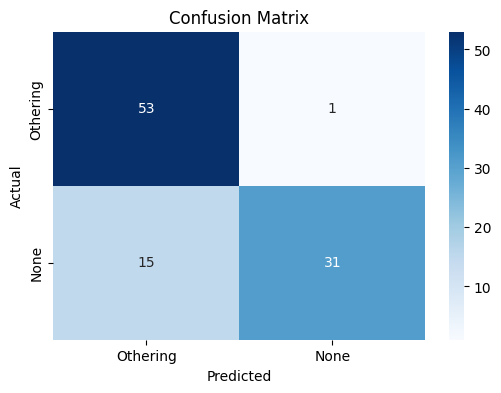

In [32]:
os.chdir(r"C:\Users\hofin\OneDrive - Fachhochschule St. Pölten\__BachelorThesis\blast_othering")

with open("data/results/82/stage_6_results_82.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.read_excel("examples.xlsx", sheet_name="Tabelle2")
df = df.replace({np.nan: "None"}) 
df = df.replace({"No": "None"})
excel_othering = df["isOthering"].astype(str).tolist()

print(f"Cohens Kappa: {get_cohens_kappa(data, df)}")
print(f"Krippendorff's Alpha: {krippendorff_alpha(data, df)}")

y_true, y_pred = [], []

for key, entry in data["data"].items():
    idx = int(key) - 1
    gold = str(df.loc[idx, "isOthering"]).strip().lower()
    pred = str(entry["annotation"]["label"]).strip().lower()
    y_true.append(gold)
    y_pred.append(pred)

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=["othering", "none"])

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Othering", "None"],
            yticklabels=["Othering", "None"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
        
        